<a href="https://colab.research.google.com/github/UW-ERSL/TOuNN/blob/main/TOuNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# # run this first time to clone the directory 
# !git clone https://github.com/UW-ERSL/TOuNN.git
# %cd TOuNN/

### Imports

In [2]:
import numpy as np
import time
# from TOuNNOptimizer import TopologyOptimizer
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.optim as optim
from os import path

from tounn.FE import FE
from tounn.plotUtil import Plotter
from tounn.network import TopNet

import matplotlib.pyplot as plt
from torch.autograd import grad

### Mesh 

In [3]:
nelx = 120; # number of FE elements along X
nely = 60; # number of FE elements along Y
elemSize = np.array([1.0, 1.0]);
mesh = {'nelx':nelx, 'nely':nely, 'elemSize':elemSize};

### Material

In [4]:
matProp = {'E':1.0, 'nu':0.3}; # Structural
matProp['penal'] = 1; # SIMP penalization constant, starting value

### Boundary Condition

In [5]:
exampleName = 'TipCantilever'
physics = 'Structural'
ndof = 2*(nelx+1)*(nely+1);
force = np.zeros((ndof,1))
dofs=np.arange(ndof);
fixed = dofs[0:2*(nely+1):1];
force[2*(nelx+1)*(nely+1)-2*nely+1, 0 ] = -1;
symXAxis = {'isOn':False, 'midPt':0.5*nely};
symYAxis = {'isOn':False, 'midPt':0.5*nelx};
bc = {'exampleName':exampleName, 'physics':physics, \
      'force':force, 'fixed':fixed, 'symXAxis':symXAxis, 'symYAxis':symYAxis };

# For more BCs see examples.py

### NN Settings

In [6]:
nnSettings = {'numLayers':3, 'numNeuronsPerLyr':20 }

### Constraints and Projections

In [7]:
densityProjection = {'isOn':True, 'sharpness':8};
desiredVolumeFraction = 0.3;

### Optimizer settings

In [8]:
minEpochs = 150; # minimum number of iterations
maxEpochs = 500; # Max number of iterations

In [9]:
class TopologyOptimizer:
    #-----------------------------#
    def __init__(self, mesh, matProp, bc, nnSettings, \
                  desiredVolumeFraction, densityProjection, overrideGPU = True):

        self.exampleName = bc['exampleName'];
        self.device = self.setDevice(overrideGPU);
        self.boundaryResolution  = 3; # default value for plotting and interpreting
        self.FE = FE(mesh, matProp, bc);
        self.xy = torch.tensor(self.FE.elemCenters, requires_grad = True).\
                                        float().view(-1,2).to(self.device);
        self.xyPlot = torch.tensor(self.FE.generatePoints(self.boundaryResolution, True),\
                        requires_grad = True).float().view(-1,2).to(self.device);
        self.Pltr = Plotter();

        self.desiredVolumeFraction = desiredVolumeFraction;
        self.density = self.desiredVolumeFraction*np.ones((self.FE.numElems));
        self.symXAxis = bc['symXAxis'];
        self.symYAxis = bc['symYAxis'];

        self.densityProjection = densityProjection;

        inputDim = 2; # x and y coordn
        self.topNet = TopNet(nnSettings, inputDim).to(self.device);
        self.objective = 0.;
    #-----------------------------#
    def setDevice(self, overrideGPU):
        if(torch.cuda.is_available() and (overrideGPU == False) ):
            device = torch.device("cuda:0");
            print("GPU enabled")
        else:
            device = torch.device("cpu")
            print("Running on CPU")
        return device;

    #-----------------------------#
    def applySymmetry(self, x):
        if(self.symYAxis['isOn']):
            xv =( self.symYAxis['midPt'] + torch.abs( x[:,0] - self.symYAxis['midPt']));
        else:
            xv = x[:,0];
        if(self.symXAxis['isOn']):
            yv = (self.symXAxis['midPt'] + torch.abs( x[:,1] - self.symXAxis['midPt'])) ;
        else:
            yv = x[:,1];
        x = torch.transpose(torch.stack((xv,yv)),0,1);
        return x;

    #-----------------------------#
    def projectDensity(self, x):
        if(self.densityProjection['isOn']):
            b = self.densityProjection['sharpness']
            nmr = np.tanh(0.5*b) + torch.tanh(b*(x-0.5));
            x = 0.5*nmr/np.tanh(0.5*b);
        return x;



def optimizeDesign(topOpt,maxEpochs, minEpochs):
    topOpt.convergenceHistory = {'compliance':[], 'vol':[], 'grayElems':[]};
    learningRate = 0.01;
    alphaMax = 100*topOpt.desiredVolumeFraction;
    alphaIncrement= 0.05;
    alpha = alphaIncrement; # start
    nrmThreshold = 0.01; # for gradient clipping
    topOpt.optimizer = optim.Adam(topOpt.topNet.parameters(), amsgrad=True,lr=learningRate);

    for epoch in range(maxEpochs):

        topOpt.optimizer.zero_grad();
        x = topOpt.applySymmetry(topOpt.xy);
        nn_rho = torch.flatten(topOpt.topNet(x)).to(topOpt.device);
        nn_rho = topOpt.projectDensity(nn_rho);
        rho_np = nn_rho.cpu().detach().numpy(); # move tensor to numpy array
        topOpt.density = rho_np;
        u, Jelem = topOpt.FE.solve(rho_np); # Call FE 88 line code [Niels Aage 2013]

        if(epoch == 0):
            topOpt.obj0 = ( topOpt.FE.Emax*(rho_np**topOpt.FE.penal)*Jelem).sum()
        # For sensitivity analysis, exponentiate by 2p here and divide by p in the loss func hence getting -ve sign

        Jelem = np.array(topOpt.FE.Emax*(rho_np**(2*topOpt.FE.penal))*Jelem).reshape(-1);
        Jelem = torch.tensor(Jelem).view(-1).float().to(topOpt.device) ;
        objective = torch.sum(torch.div(Jelem,nn_rho**topOpt.FE.penal))/topOpt.obj0; # compliance

        volConstraint =((torch.mean(nn_rho)/topOpt.desiredVolumeFraction) - 1.0); # global vol constraint
        currentVolumeFraction = np.average(rho_np);
        topOpt.objective = objective;
        loss =   topOpt.objective+ alpha*torch.pow(volConstraint,2);

        alpha = min(alphaMax, alpha + alphaIncrement);
        loss.backward(retain_graph=True);
        torch.nn.utils.clip_grad_norm_(topOpt.topNet.parameters(),nrmThreshold)
        topOpt.optimizer.step();

        greyElements= sum(1 for rho in rho_np if ((rho > 0.2) & (rho < 0.8)));
        relGreyElements = topOpt.desiredVolumeFraction*greyElements/len(rho_np);
        topOpt.convergenceHistory['compliance'].append(topOpt.objective.item());
        topOpt.convergenceHistory['vol'].append(currentVolumeFraction);
        topOpt.convergenceHistory['grayElems'].append(relGreyElements);
        topOpt.FE.penal = min(8.0,topOpt.FE.penal + 0.02); # continuation scheme

        if(epoch % 20 == 0):
            titleStr = "Iter {:d} , Obj {:.2F} , vol {:.2F}".format(epoch, topOpt.objective.item()*topOpt.obj0, currentVolumeFraction);
            topOpt.Pltr.plotDensity(topOpt.xy.detach().cpu().numpy(), rho_np.reshape((topOpt.FE.nelx, topOpt.FE.nely)), titleStr);
            print(titleStr);
        if ((epoch > minEpochs ) & (relGreyElements < 0.025)):
            break;
    topOpt.Pltr.plotDensity(topOpt.xy.detach().cpu().numpy(), rho_np.reshape((topOpt.FE.nelx, topOpt.FE.nely)), titleStr);
    print("{:3d} J: {:.2F}; Vf: {:.3F}; loss: {:.3F}; relGreyElems: {:.3F} "\
            .format(epoch, topOpt.objective.item()*topOpt.obj0 ,currentVolumeFraction,loss.item(),relGreyElements));

    print("Final J : {:.3f}".format(topOpt.objective.item()*topOpt.obj0));
    topOpt.Pltr.plotConvergence(topOpt.convergenceHistory);

    x = topOpt.applySymmetry(topOpt.xyPlot);
    rho = torch.flatten(topOpt.projectDensity(topOpt.topNet(x)));
    rho_np = rho.cpu().detach().numpy();

    titleStr = "Iter {:d} , Obj {:.2F} , vol {:.2F}".format(epoch, topOpt.objective.item()*topOpt.obj0, currentVolumeFraction);
    topOpt.Pltr.plotDensity(topOpt.xyPlot.detach().cpu().numpy(), rho_np.reshape((topOpt.FE.nelx*topOpt.boundaryResolution, topOpt.FE.nely*topOpt.boundaryResolution)), titleStr);
    return topOpt.convergenceHistory;

/home/ab/anaconda3/envs/porous/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Running on CPU


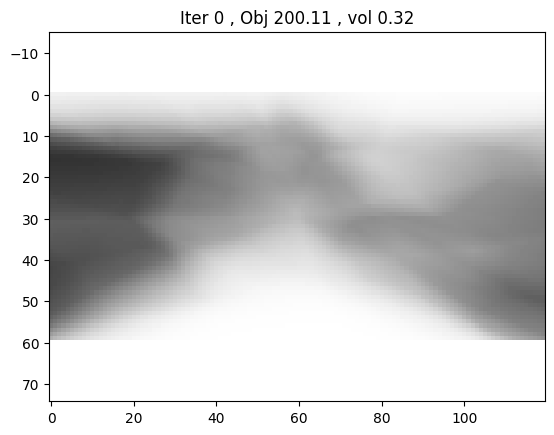

Iter 0 , Obj 200.11 , vol 0.32


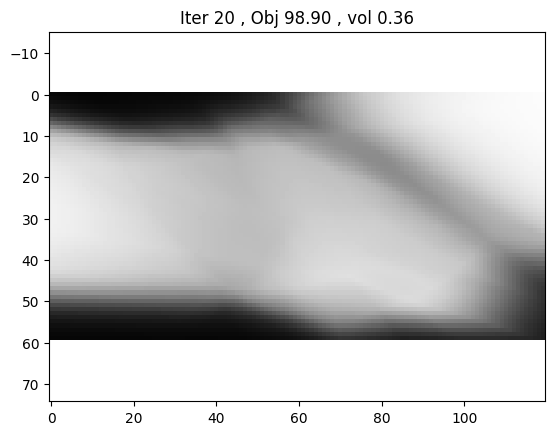

Iter 20 , Obj 98.90 , vol 0.36


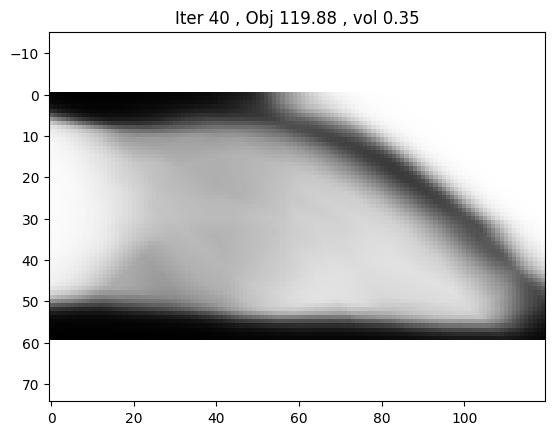

Iter 40 , Obj 119.88 , vol 0.35


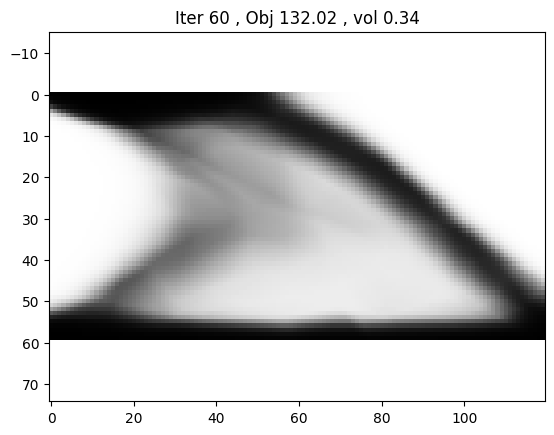

Iter 60 , Obj 132.02 , vol 0.34


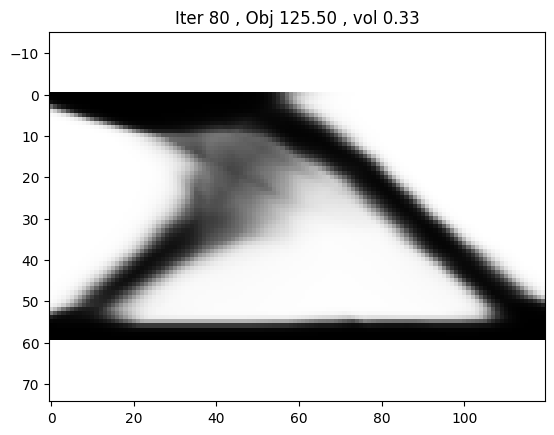

Iter 80 , Obj 125.50 , vol 0.33


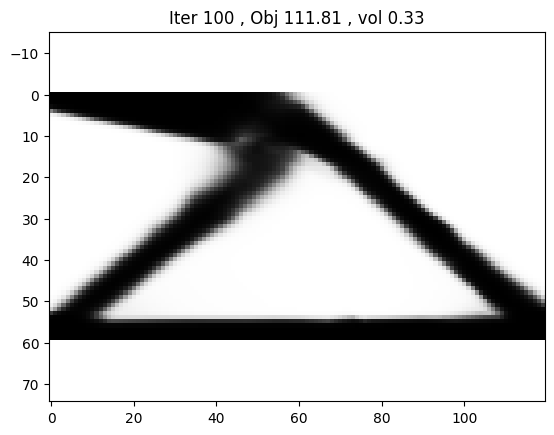

Iter 100 , Obj 111.81 , vol 0.33


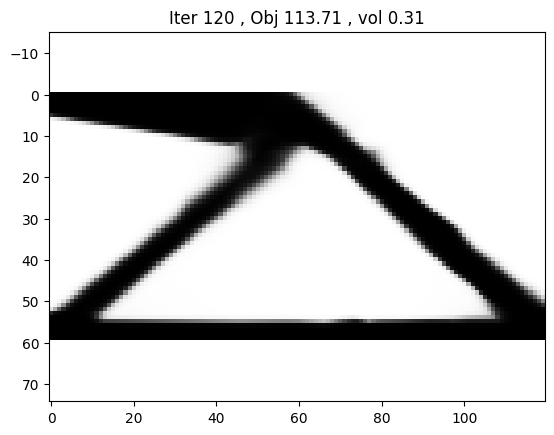

Iter 120 , Obj 113.71 , vol 0.31


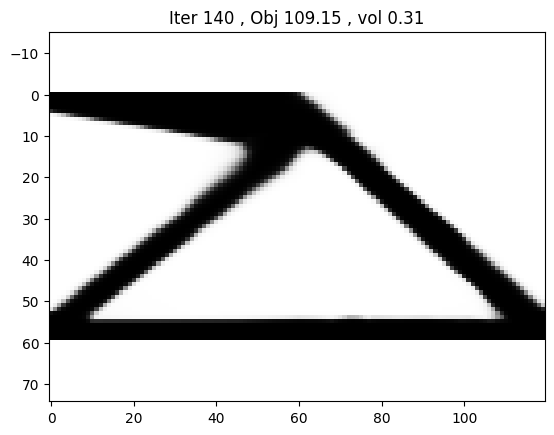

Iter 140 , Obj 109.15 , vol 0.31


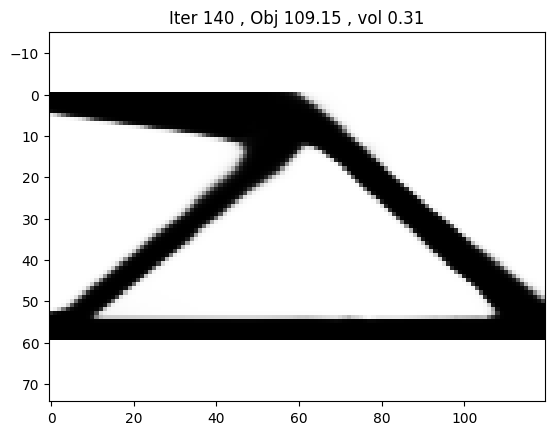

151 J: 108.41; Vf: 0.307; loss: 0.546; relGreyElems: 0.010 
Final J : 108.411


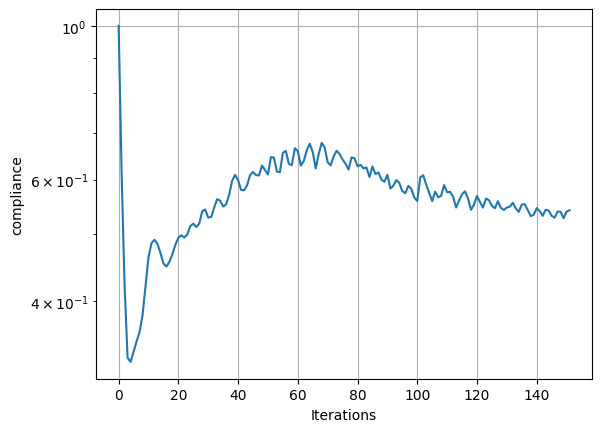

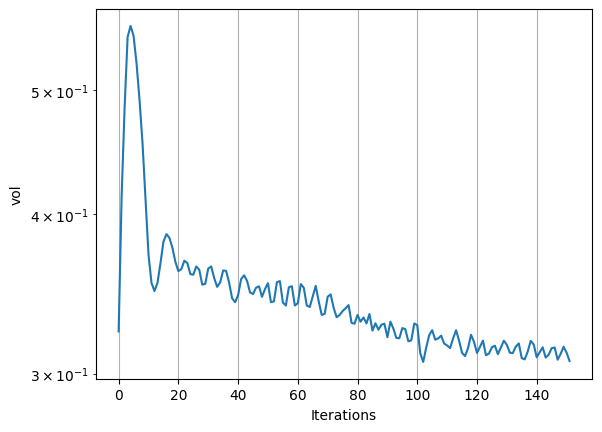

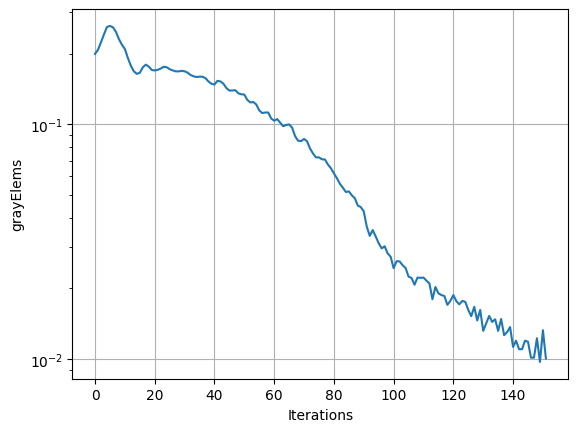

<Figure size 640x480 with 0 Axes>

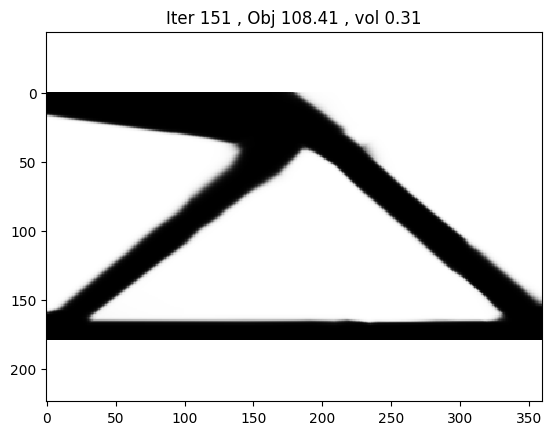

Time taken (secs): 10.70


In [10]:
plt.close('all');
overrideGPU = False
start = time.perf_counter()
topOpt = TopologyOptimizer(mesh, matProp, bc, nnSettings, \
                  desiredVolumeFraction, densityProjection, overrideGPU);
optimizeDesign(topOpt, maxEpochs,minEpochs);
print("Time taken (secs): {:.2F}".format( time.perf_counter() - start))